In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from dataloader import *
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

2024-01-03 11:27:01.679869: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-03 11:27:01.681178: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-03 11:27:01.708948: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-03 11:27:02.198204: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Le ECL dataset est un dataset sur la consommation d'electricité de 321 clients toutes les heures entre 2012 et 2014.   
Les colonnes représentent les 321 clients et il y a 26 304 lignes. 
 

## Load data

In [2]:
ecl_data = pd.read_csv('electricity.csv', header=None).to_numpy()

In [3]:
# Diviser les données en ensembles de train, test et validation
train_data = ecl_data[:18317]
test_data = ecl_data[18317:18317+2633]
val_data = ecl_data[18317+2633:]

In [134]:
batch_size = 32

train_dataset = MonDataLoader(ecl_data[:18317], 96, 96)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

eval_dataset = MonDataLoader(ecl_data[18317+2633:], 96, 96)
eval_loader = DataLoader(eval_dataset, batch_size=batch_size, shuffle=False)

test_dataset = MonDataLoader(ecl_data[18317:18317+2633], 96, 96)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [135]:
for x,y in train_loader: 
    print(x.shape)
    print(y.shape)
    break

torch.Size([32, 96, 321])
torch.Size([32, 96, 321])


## Modèle

In [136]:
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MLP, self).__init__()
        self.mlp = nn.Sequential(
          nn.Linear(input_dim, input_dim),
          nn.ReLU(),
          nn.Linear(input_dim, output_dim),
          nn.ReLU(),
          nn.Linear(output_dim, output_dim), 
        )

    def forward(self, x):
        x = self.mlp(x)
        return x


class FeedForward(nn.Module):
    def __init__(self, input_dim):
        super(FeedForward, self).__init__()
        self.feed_forward = nn.Sequential(
          nn.Linear(input_dim, input_dim*4),
          nn.GELU(),
          nn.Dropout(),
          nn.Linear(input_dim*4, input_dim), 
        )

    def forward(self, x):
        x = self.feed_forward(x)
        return x

class TrmBlock(nn.Module):
    def __init__(self, embed_dim):
      super(TrmBlock, self).__init__()

      self.multivariate_attention= nn.MultiheadAttention(embed_dim, num_heads=1)
      self.layer_norm1 = nn.LayerNorm(embed_dim)
      self.feed_forward = FeedForward(embed_dim)
      self.layer_norm2 = nn.LayerNorm(embed_dim)

    def forward(self, x):
      att,_ = self.multivariate_attention(x,x,x)
      x= self.layer_norm1(x + att)
      x= self.layer_norm2(x + self.feed_forward(x))
      return x


class iTransformer(nn.Module):
    def __init__(self, T, D, S, num_blocks):
      super(iTransformer, self).__init__()

      self.embedding= MLP(T, D)
      self.trmblock= nn.ModuleList([TrmBlock(D) for _ in range(num_blocks)])
      self.projection= MLP(D, S)


    def forward(self, x):
      #print(x.shape)
      x = x.transpose(1,2)
      #print('transpose ', x.shape)
      x = self.embedding(x)
      #print('emb ',x.shape)
      for block in self.trmblock:
            x = block(x)
      #print('trmblock ',x.shape)
      y = self.projection(x)
      #print('proj ', y.shape)
      y=y.transpose(1,2)
      #print('final ', y.shape)
      return y

In [137]:
N = 321 #nb variables
T = 96 #input length (lookback window)
D = 256 # ou 512
S = 96 # ou 192, 336, 720
#hidden_dim = 176 #dimension latente dans le feed forward du transformer 
num_blocks = 2 #3 ou 4 (nombre de block de transformer)

itransformer = iTransformer(T, D, S, num_blocks)

for x,y in train_loader:
    x, y = x.float(), y.float()

    yhat = itransformer(x)
    print(yhat.shape)
    break

torch.Size([32, 96, 321])


## Train

In [138]:
def MAE(pred, true):
    return np.mean(np.abs(pred - true))

In [139]:
def MSE(pred, true):
    return np.mean((pred - true) ** 2)

In [140]:
def eval(model, val_loader, device, criterion, writer, epoch):
    model.eval()

    epoch_loss = []
    #epoch_accuracy = []
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            data, target = data.float().to(device), target.float().to(device)
            yhat = model(data)
            loss = criterion(yhat, target)
            
            epoch_loss.append(loss.item())
            #epoch_accuracy.append()

        """
        writer.add_scalar('Loss validation', np.mean(epoch_loss), epoch)
    
        for name, weight in model.named_parameters():
            writer.add_histogram(name, weight, epoch)
            writer.add_histogram(f'{name}.grad', weight.grad, epoch)

        entropie = criterion(logits,target)
        writer.add_histogram('Entropy validation', entropie, epoch)
        
        writer.add_scalar('Accuracy validation', np.mean(epoch_accuracy), epoch)
        """

        return np.mean(epoch_loss)
        

In [141]:
def train(model, optimizer, train_loader, val_loader, nb_epoch, device, writer):
    
    criterion = nn.MSELoss()
    
    loss_values = []
    loss_eval = []


    for epoch in range(nb_epoch):
        print("epoch : ", epoch)

        model.train()
        epoch_loss = []

        for i, (data, target) in enumerate(train_loader):
            data, target = data.float().to(device), target.float().to(device)
            optimizer.zero_grad()

            yhat = model(data)
            loss = criterion(yhat, target)

            epoch_loss.append(loss.item())

            loss.backward()
            optimizer.step()


        loss_values.append(np.mean(epoch_loss))

        """
        writer.add_scalar('Loss train', np.mean(epoch_loss), epoch)
    
        for name, weight in model.named_parameters():
            writer.add_histogram(f'{name}', weight, epoch)
            writer.add_histogram(f'{name}.grad', weight.grad, epoch)

        entropie = criterion(logits,target)
        writer.add_histogram('Entropy train', entropie, epoch)
        
        writer.add_scalar('Accuracy train', np.mean(epoch_accuracy), epoch)

        """

        epoch_loss_eval = eval(model, val_loader, device, criterion, writer, epoch)
        loss_eval.append(epoch_loss_eval)
        print("loss train :", loss_values[-1])
        print("loss eval :", loss_eval[-1])

        
    return loss_values, loss_eval

## Test

In [142]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
writer = SummaryWriter()

cpu


In [143]:
N = 321 #nb variables
T = 96 #input length (lookback window)
D = 256 # ou 512
S = 96 # ou 192, 336, 720
#hidden_dim = 176 #dimension latente dans le feed forward du transformer 
num_blocks = 2 #3 ou 4 (nombre de block de transformer)

itransformer = iTransformer( T, D, S, num_blocks)
optimizer = torch.optim.Adam(itransformer.parameters(), lr=1e-3) #10−3, 5 × 10−4, 10−4 



In [144]:
loss_values, loss_eval = train(itransformer, optimizer, train_loader, eval_loader, 10, device, writer)

epoch :  0
loss train : 233341544.0
loss eval : 265632720.0
epoch :  1
loss train : 233332726.66666666
loss eval : 265614864.0
epoch :  2
loss train : 233304061.33333334
loss eval : 265564688.0
epoch :  3
loss train : 233232782.66666666
loss eval : 265452736.0
epoch :  4
loss train : 233085189.33333334
loss eval : 265237200.0
epoch :  5
loss train : 232816232.0
loss eval : 264866368.0
epoch :  6
loss train : 232373357.33333334
loss eval : 264285424.0
epoch :  7
loss train : 231706601.33333334
loss eval : 263450416.0
epoch :  8
loss train : 230789058.66666666
loss eval : 262360344.0
epoch :  9
loss train : 229652272.0
loss eval : 261097424.0


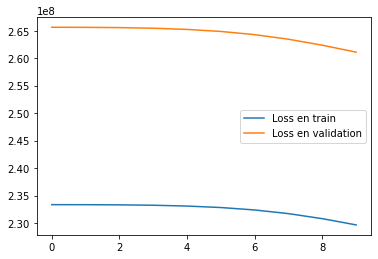

In [149]:
plt.figure()
plt.plot(loss_values,label="Loss en train")
plt.plot(loss_eval,label="Loss en validation")
plt.legend()
plt.show()

In [152]:
def test(model, test_loader):
    model.eval()
    criterion = nn.MSELoss(reduction='mean')
    loss_batch = []
    with torch.no_grad():
        for _, (data, target) in enumerate(test_loader):
            data, target = data.float().to(device), target.float().to(device)
            yhat = model(data)
            loss = criterion(yhat, target)
            loss_batch.append(loss.item())

            plt.figure()
            plt.plot(target[0][:][0],label="target")
            plt.legend()
            plt.show()
            plt.figure()
            plt.plot(yhat[0][:][0],label="prediction")
            plt.legend()
            plt.show()
            break

        """
        if write_tensorboard:

            writer.add_scalar('Loss validation', np.mean(epoch_loss), epoch)
        
            for name, weight in model.named_parameters():
                writer.add_histogram(name, weight, epoch)
                writer.add_histogram(f'{name}.grad', weight.grad, epoch)

            entropie = criterion(logits,target)
            writer.add_histogram('Entropy validation', entropie, epoch)
            
            writer.add_scalar('Accuracy validation', np.mean(epoch_accuracy), epoch)
        """
        print(loss_batch)
        return np.mean(loss_batch)

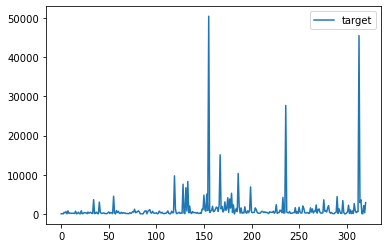

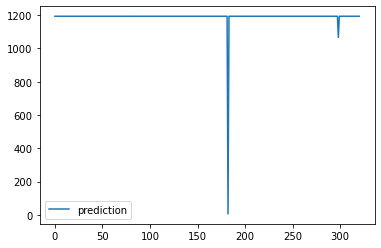

[121220984.0]
MSE :  121220984.0


In [153]:
loss_test = test(itransformer, test_loader )
print("MSE : ", loss_test)